# Workspace \#11: Projections

In [4]:
%matplotlib notebook

In [5]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import ticker
# from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm
from glob import glob

# matplotlib style
#%matplotlib inline

#%config InlineBackend.figure_format = "retina"
#rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

from multiprocessing import Pool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from random import random

import sys
sys.path.insert(0, '../')

import tools as tl
import constants as ct
import particle as pt
import ska as sk
import astro as ap
import echo as ec
import routines as rt
import data as dt

/home/chen/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Optical depth cross check

Model (a) of Gregory and Seaquist 1974

<IPython.core.display.Javascript object>


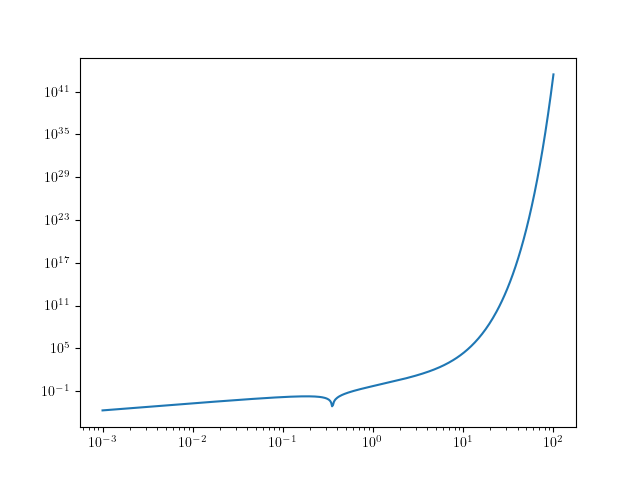

In [4]:
tau_m_arr = np.logspace(-3, 2, 500)
gamma = 2

plt.subplots()
plt.plot(tau_m_arr, np.abs(np.exp(tau_m_arr) - ((gamma+4.)/5 * tau_m_arr + 1.)))
plt.yscale('log')
plt.xscale('log')

In [13]:
from scipy.optimize import root_scalar

In [14]:
def find_tau_m(gamma):
    def func(tau):
        return (np.exp(tau) - ((gamma+4.)/5 * tau + 1.))
    res = root_scalar(func, bracket=[1e-10, 10], method='brentq')
    return res.root

find_tau_m(3.)

0.6390296264710424

<IPython.core.display.Javascript object>


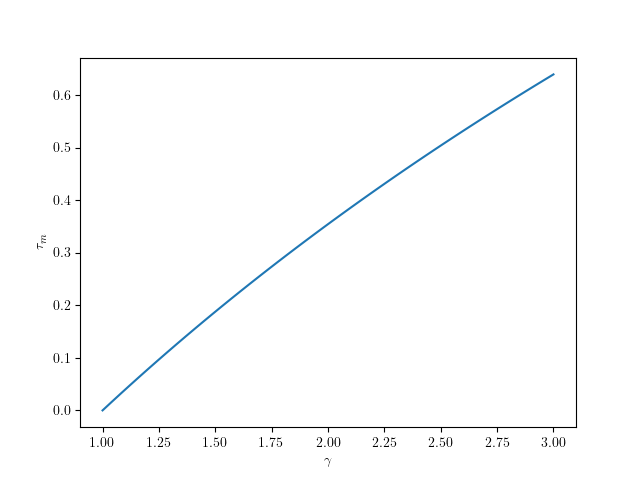

Text(0, 0.5, '$\\tau_m$')

In [15]:
plt.subplots()
gamma_arr = np.linspace(1, 3)
tau_arr = np.array([find_tau_m(gamma) for gamma in gamma_arr])
plt.plot(gamma_arr, tau_arr)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\tau_m$')

In [16]:
twopi_GHz_over_eV = 4.13357119850271e-06

In [17]:
def tau(nu, EM, Te):
    """ 
    nu: [GHz]
    EM: emission measure [cm^-6*pc]
    Te: temperature of electrons [K]
    """
    res = 6.35e17 * (EM) * Te**(-1.38) * (nu/(1e-9))**(-2.08)
    return res

tau(1, 1, 5000)

9.510319762021515e-07

In [18]:
tau(1, 0.015**2*1000, 5000)

2.139821946454841e-07

<IPython.core.display.Javascript object>


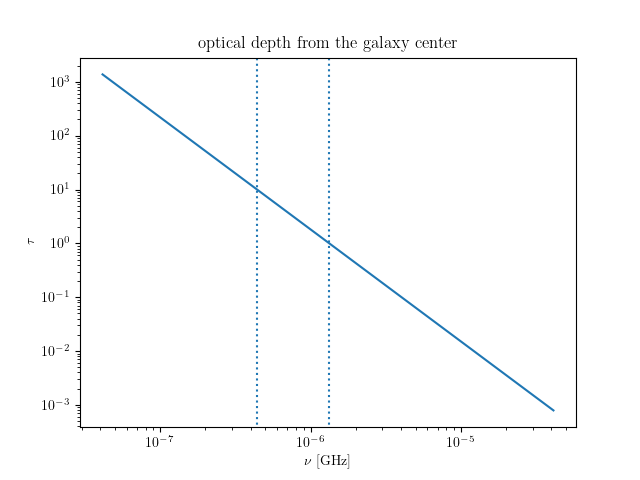

0.3226618752492872
0.10665431303534932


In [19]:
plt.subplots()
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$\tau$')
plt.title('optical depth from the galaxy center')

nu_arr = np.logspace(-2, 1)
E_arr = nu_arr * twopi_GHz_over_eV
plt.plot(E_arr, tau(nu_arr, EM=1e5, Te=5000))
y0, y1 = plt.ylim()
plt.ylim(y0, y1)

# solve
def func(nu):
    return tau(nu, EM=1e5, Te=5000)-1.
res = root_scalar(func, bracket=[1e-10, 10], method='brentq')
nu0 = res.root
print(nu0)
plt.vlines(nu0*twopi_GHz_over_eV, 1e-5, 1e5, ls=':')

# solve 2
def func(nu):
    return tau(nu, EM=1e4, Te=5000)-1.
res = root_scalar(func, bracket=[1e-10, 10], method='brentq')
nu0 = res.root
print(nu0)
plt.vlines(nu0*twopi_GHz_over_eV, 1e-5, 1e5, ls=':')

#plt.savefig('/home/chen/Dropbox/Research/axion_stim_decays/SNR_Ghost_draft/figs/optical_depth.pdf')

# Other axion constraints

In [7]:
sys.path.insert(0, '../../../AxionLimits/')
from PlotFuncs_mod import AxionPhoton
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('font', family='serif',size=25)
#plt.rc('text', usetex=True)
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{mathpazo}']

In [8]:
def gen_constraints(show_bounds=True):
    fig, ax = plt.subplots(figsize=(10,7))
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1.5e-12, 1e-9)
    plt.xlim(1e-7, 1e-3)
    plt.xlabel(r'$m_a$ [eV]')
    plt.ylabel(r'$g_{a\gamma}$ [GeV$^{-1}$]')

    fs = 20 # fontsize
    text_on = True
    projection = False

    if show_bounds:
    # AxionPhoton.Haloscopes(ax)
    # hand-pick those from Haloscopes 
    # the references are here: 
    # https://github.com/cajohare/AxionLimits/tree/master/refs
        AxionPhoton.ADMX(ax,projection=projection,fs=fs,text_on=text_on, col=[0.8, 0.8, 0.8], text_shift=[1.7, 0.6e2])
        AxionPhoton.RBF_UF(ax,fs=fs-2,text_on=text_on, col=[0.8, 0.8, 0.8], text_shift=[1.1, 1.5])
        AxionPhoton.HAYSTAC(ax,projection=projection,text_on=text_on, col=[0.8, 0.8, 0.8], fs=13, text_shift=[0.8, 15])
        AxionPhoton.CAPP(ax,fs=fs-4,text_on=text_on, col=[0.4, 0.4, 0.4], text_shift=[1.1,400])
        AxionPhoton.ORGAN(ax,projection=projection,text_on=text_on, col=[0.8, 0.8, 0.8], fs=15, text_shift=[1,0.6])
        AxionPhoton.ADMX_SLIC(ax,fs=fs-8,text_on=text_on, col=[0.8, 0.8, 0.8], text_shift=[0.6,1])
        AxionPhoton.QUAX(ax,text_on=text_on, text_shift=[0.8, 0.5], col=[0.8, 0.8, 0.8])
        AxionPhoton.Helioscopes(ax, text_shift=[3e-2, 0.9], col=[0.6, 0.6, 0.6])
        AxionPhoton.NeutronStars(ax, fs=fs, text_shift=[6,0.15], col=[0.6, 0.6, 0.6])
    #plt.tight_layout()
    return fig, ax

<IPython.core.display.Javascript object>


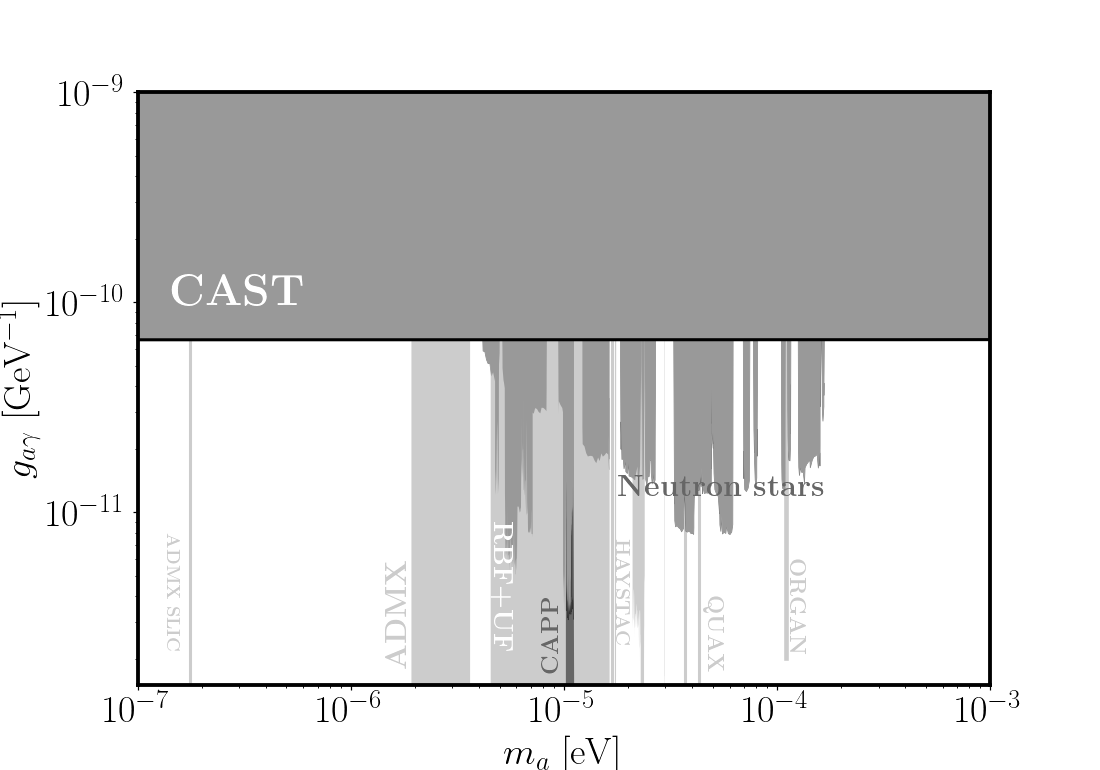

In [9]:
fig, _ = gen_constraints()

# Single benchmarks in ($m_a, g_{a\gamma}$)

TODO: 

1. double check the formula to be used for the signal --DONE
1. check if denser DM increases or descreases the signal --DONE
1. check the $(\ell, b)$ dependence
1. make new $m_a-g_a$ contours
    1. just shift local density by some constant, say $4\times 10^4$ years
    1. increase $S_{\nu,0}$
    1. increase number of SNR's
1. refine the abberation and moving-out-of-spotlight effect    


In [38]:
ct._casA_solid_angle_ 

1.6614302187698022e-06

### Example 0

In [38]:
ct.angle_to_solid_angle(48/60/180*3.14)

0.00015296158641312673

In [43]:
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 6.4 #175 #175 #178 #10 #179 # 111.734745
latitude = -0.1 # -02.129570
D = 1.8 #0.5 #[kpc]

alpha = 0.7
gamma = ap.gamma_from_alpha(alpha)
nu_Biet = 8.
nu_pivot = 1.
t_peak = 100.*365  #100 * 365
t_trans = t_peak /365
t_age = 35000.
S0 = 310 #Jy
L_today = S0 * ct._Jy_over_cgs_irrad_ * 4.*np.pi * (D*ct._kpc_over_cm_)**2
ang_size = 1.5e-4 #None #1.5e-4#None #snr_ang_size(D) #1.7e-4 #1e-6 #1e-5 #1e-4 #


source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':t_age, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma, # Cas A experiment
#                 'gamma':(2.032 * 1.3/0.7), # a detected 1.3% decay rather than 0.7%
#                 'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                #'model':'eff', 'L_today':LumCasA, 't_trans':10.,
                #'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans,
                'model': "eff", 'L_today': L_today, 't_peak': t_peak, 't_trans': t_trans,
                'force_Omega_disp_compute': True,
                'use_free_expansion': False
               }

ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)

data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':1,
        'DM_profile': DM_profile,
        'correlation_mode': "interferometry"#"single dish"
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':0.}

### t_extra_old slices

In [44]:
Nma = 501
nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)

ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
ga_new = ga_ref


routine_out = {}
bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                             source_input=source_input,
                             data=data,
                             Snu_echo_kwargs=Snu_echo_kwargs)


data['correlation_mode'] = 'single dish'
routine_out = {}
bounds_out_single = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                             source_input=source_input,
                             data=data,
                             Snu_echo_kwargs=Snu_echo_kwargs)
    


Signal computed and saved in:

output['signal_nu']	[GHz]
output['signal_delnu']	[GHz]
output['signal_Omega']	[sr]\noutput['signal_Snu']	[Jy]
output['signal_S_echo']		[eV^4]
output['signal_power']	[eV^2]

Noise computed and saved in:

output['noise_nu']	[GHz]
output['noise_delnu']	[GHz]
output['noise_Omega_res']	[sr]
output['noise_Omega_obs']	[sr]
output['noise_T408']	[K]
output['noise_Tnu']	[K]
output['noise_power']	[eV^2]

Signal computed and saved in:

output['signal_nu']	[GHz]
output['signal_delnu']	[GHz]
output['signal_Omega']	[sr]\noutput['signal_Snu']	[Jy]
output['signal_S_echo']		[eV^4]
output['signal_power']	[eV^2]

Noise computed and saved in:

output['noise_nu']	[GHz]
output['noise_delnu']	[GHz]
output['noise_Omega_res']	[sr]
output['noise_Omega_obs']	[sr]
output['noise_T408']	[K]
output['noise_Tnu']	[K]
output['noise_power']	[eV^2]



/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:336: RuntimeWarning: invalid value encountered in true_divide
  new_output['S/N'] = new_output['signal_power'] / new_output['noise_power']


In [45]:
print(ct.angle_to_solid_angle(100/60/180*3.1415926))
print(ct.angle_to_solid_angle(3.6/60/180*3.1415926))
print(ct.angle_to_solid_angle(25.2/60/180*3.1415926))

0.0006645603788945126
8.612854142200671e-07
4.220293901904649e-05


<IPython.core.display.Javascript object>


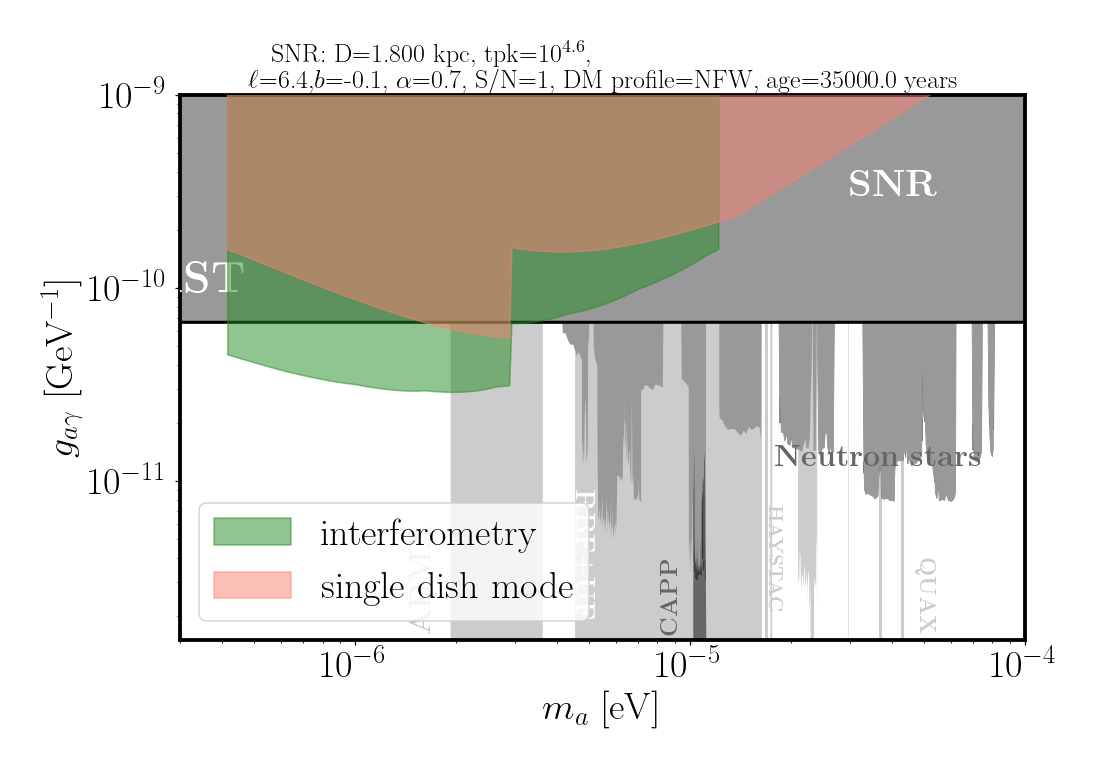

In [46]:
fig, ax = gen_constraints();

ghosh = np.loadtxt("../data/cygA_bounds.csv", delimiter=",")
z_val = 1. #2.


ga_reach = ec.ga_reach(z_val, bounds_out['S/N'], bounds_out['ga'])
ma_ga = np.vstack((ma_new, ga_reach)).T
ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., label='interferometry', color='forestgreen', alpha=0.5, zorder=100)

ga_reach = ec.ga_reach(z_val, bounds_out_single['S/N'], bounds_out_single['ga'])
ma_ga = np.vstack((ma_new, ga_reach)).T
ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., label='single dish mode', color='salmon', alpha=0.5, zorder=101)


ax.text(3e-5, 3e-10, r"{\bf SNR}", fontdict={'size':25}, color='w', zorder=101)


title_str = r"SNR: D={D:.3f} kpc, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}, DM profile={DM_profile}, age={age} years"
title = title_str.format(D=D,
                 #log10Lpk=np.log10(L_peak_Biet), 
                 log10tpk=np.log10(t_peak),
                 ell=longitude,
                 b=latitude,
                 alpha=alpha,
                 #sr=ang_size, 
                 sn=z_val,
                 DM_profile=DM_profile,
                        age=source_input['t_age'])

ax.set_title(title, fontdict={'fontsize': 17})
plt.xlim(3e-7, 1e-4)
#plt.ylim(1e-13, 1e-9)
plt.legend(loc=3)
fig.tight_layout()
plt.savefig('../plots/projection_old_logLpk_%.1f_logtpk_%.1f_ell_%.1f_b_%.1f_snr_%d_D_%.1f_alpha_%.1f_%s.png' %(0, np.log10(t_peak), longitude, latitude, z_val, D, alpha, DM_profile))



In [48]:
pt.ma_from_nu(0.3)

2.481400683498048e-06

In [47]:
ap.T_noise(1., Tr=40)

48.47053053656275

In [49]:
ap.T_noise(1., Tbg_at_408=461, Tr=40)

92.59435471686767

In [50]:
ap.bg_408_temp(l=-6.4, b=0.1, size=1.5e-4, average=True, verbose=False)  # [K]

array(461.2647, dtype=float32)

### Example 1

In [60]:
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 175. #175 #175 #178 #10 #179 # 111.734745
latitude = 0. # -02.129570
D = 0.5 #0.5 #[kpc]

alpha = 0.5
gamma = ap.gamma_from_alpha(alpha)
nu_Biet = 8.
nu_pivot = 1.
L_peak_Biet = 10**(25.5+1.6*2.)
L_peak = L_peak_Biet * (nu_Biet/nu_pivot) ** alpha
#L_peak = 10**(25.5+1.6*2.)
t_peak = 10**1.7
t_trans = t_peak * 30./365
ang_size = None #snr_ang_size(D) #1.7e-4 #1e-6 #1e-5 #1e-4 #


source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':1e4, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma, # Cas A experiment
#                 'gamma':(2.032 * 1.3/0.7), # a detected 1.3% decay rather than 0.7%
#                 'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                #'model':'eff', 'L_today':LumCasA, 't_trans':10.,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans,
                'force_Omega_disp_compute': True
               }

ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)

data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile,
        'correlation_mode': "interferometry"#"interferometry"#"single dish"        
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}

### t_extra_old slices

In [61]:
Nma = 501
nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)

ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
ga_new = ga_ref

res_dct = {}
#t_extra_old_arr = [1.e2, 1.e3, 1.e4, 2e4, 3e4, 4e4, 5e4]
#t_extra_old_arr = [0, 1.e4, 2e4, 3e4, 4e4, 5e4]
#t_extra_old_arr = [0, 1.e4, 3e4, 5e4]
#t_extra_old_arr = [0, 5e4]
#t_extra_old_arr = [3e4, 4e4, 5e4]
#t_extra_old_arr = [0]
t_extra_old_arr = [4e4]
for t_extra_old in t_extra_old_arr:
    Snu_echo_kwargs['t_extra_old'] = t_extra_old
    #print(Snu_echo_kwargs)
    routine_out = {}
    bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                 source_input=source_input,
                                 data=data,
                                 Snu_echo_kwargs=Snu_echo_kwargs)
    res_dct[str(int(t_extra_old))] = bounds_out

#area, window, Tr = rt.SKA_rescaled_specs(ma_new, data=data)

/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:336: RuntimeWarning: invalid value encountered in true_divide
  new_output['S/N'] = new_output['signal_power'] / new_output['noise_power']


<IPython.core.display.Javascript object>


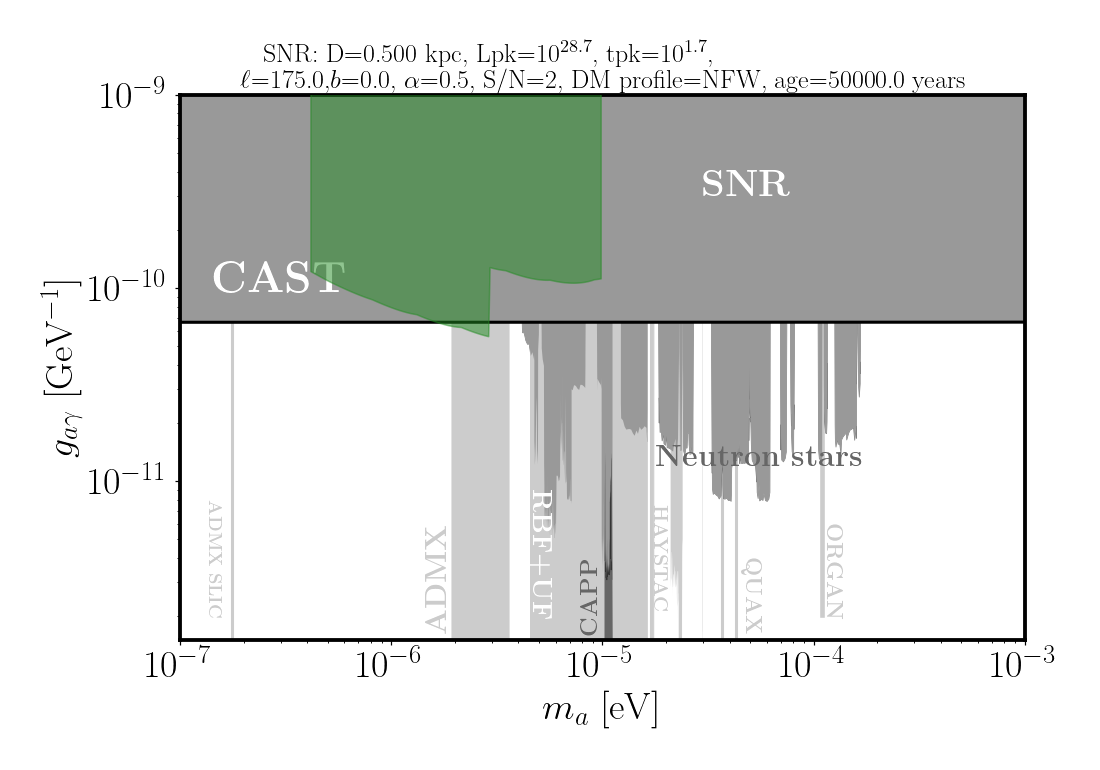

In [62]:
fig, ax = gen_constraints();

ghosh = np.loadtxt("../data/cygA_bounds.csv", delimiter=",")
z_val = 2.
# plt.subplots()
# plt.xlabel('$m_a$ [eV]')
# plt.ylabel('$g_{a\gamma\gamma}$ [GeV$^{-1}$]')
# plt.axhline(6.e-11, color='k', ls=':')

# existing echo bounds
# ax.plot(ghosh[:,0], ghosh[:,1]*sqrt(z_val), color=[0.5,0.5,0.5], ls='--')


for key in t_extra_old_arr: #res_dct.keys():
    key = str(int(key))
    bounds_out = res_dct[key]
    ga_reach = ec.ga_reach(z_val, bounds_out['S/N'], bounds_out['ga'])
    ma_ga = np.vstack((ma_new, ga_reach)).T
    #ax.loglog(ma_ga[:,0], ma_ga[:,1], label='%s' %key)
    ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., label='%s' %key, color='forestgreen', alpha=0.5, zorder=100)

ax.text(3e-5, 3e-10, r"{\bf SNR}", fontdict={'size':25}, color='w', zorder=101)
# ax.set_xscale("log");ax.set_yscale("log");
#ax.set_ylim(1.e-13, 1.e-8);
#ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.), ncol=len(t_extra_old_arr), prop={'size': 10})
#ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.), ncol=1, prop={'size': 10})


title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}, DM profile={DM_profile}, age={age} years"
title = title_str.format(D=D,
                 log10Lpk=np.log10(L_peak_Biet), 
                 log10tpk=np.log10(t_peak),
                 ell=longitude,
                 b=latitude,
                 alpha=alpha,
                 #sr=ang_size, 
                 sn=z_val,
                 DM_profile=DM_profile,
                        age=source_input['t_age']+t_extra_old_arr[0])

ax.set_title(title, fontdict={'fontsize': 17})
fig.tight_layout()
plt.savefig('../plots/projection_old_logLpk_%.1f_logtpk_%.1f_ell_%.1f_b_%.1f_snr_%d_D_%.1f_alpha_%.1f_%s_tex_%.0f.png' %(np.log10(L_peak), np.log10(t_peak), longitude, latitude, z_val, D, alpha, DM_profile, t_extra_old_arr[0]))



### Example 2

In [73]:
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 0. #175 #175 #178 #10 #179 # 111.734745
latitude = 0. # -02.129570
D = 0.2 #0.5 #[kpc]

alpha = 0.5
gamma = ap.gamma_from_alpha(alpha)
nu_Biet = 8.
nu_pivot = 1.
L_peak_Biet = 10**(25.5+1.6*2.)
L_peak = L_peak_Biet * (nu_Biet/nu_pivot) ** alpha
#L_peak = 10**(25.5+1.6*2.)
t_peak = 10**1.7
t_trans = t_peak * 30./365
ang_size = None #snr_ang_size(D) #1.7e-4 #1e-6 #1e-5 #1e-4 #


source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':6, #1e4, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma, # Cas A experiment
#                 'gamma':(2.032 * 1.3/0.7), # a detected 1.3% decay rather than 0.7%
#                 'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                #'model':'eff', 'L_today':LumCasA, 't_trans':10.,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans,
                'force_Omega_disp_compute': True
               }

ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)

data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile,
        'correlation_mode': "interferometry"#"single dish"#"interferometry"        
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}

### t_extra_old slices

In [74]:
Nma = 501
nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)

ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
ga_new = ga_ref

res_dct = {}
#t_extra_old_arr = [1.e2, 1.e3, 1.e4, 2e4, 3e4, 4e4, 5e4]
#t_extra_old_arr = [0, 1.e4, 2e4, 3e4, 4e4, 5e4]
#t_extra_old_arr = [0, 1.e4, 3e4, 5e4]
#t_extra_old_arr = [0, 5e4]
#t_extra_old_arr = [3e4, 4e4, 5e4]
t_extra_old_arr = [0]
#t_extra_old_arr = [4e4]
for t_extra_old in t_extra_old_arr:
    Snu_echo_kwargs['t_extra_old'] = t_extra_old
    #print(Snu_echo_kwargs)
    routine_out = {}
    bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                 source_input=source_input,
                                 data=data,
                                 Snu_echo_kwargs=Snu_echo_kwargs)
    res_dct[str(int(t_extra_old))] = bounds_out

#area, window, Tr = rt.SKA_rescaled_specs(ma_new, data=data)

/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:336: RuntimeWarning: invalid value encountered in true_divide
  new_output['S/N'] = new_output['signal_power'] / new_output['noise_power']


<IPython.core.display.Javascript object>


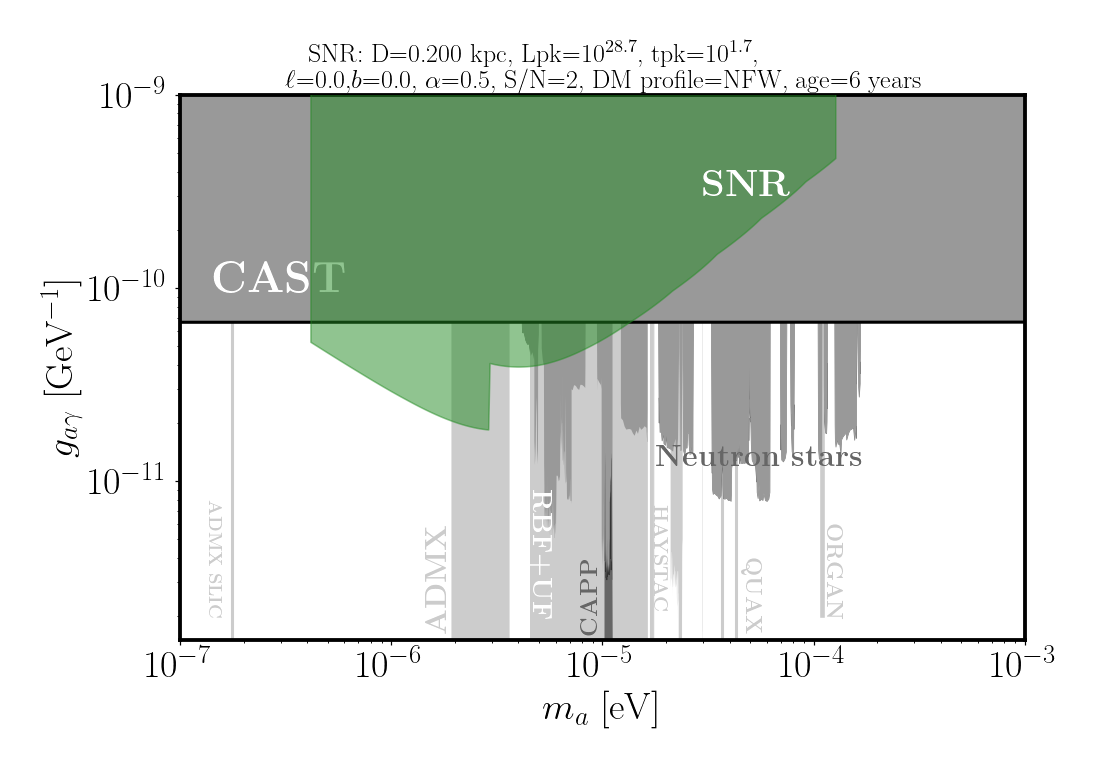

In [75]:
fig, ax = gen_constraints();

ghosh = np.loadtxt("../data/cygA_bounds.csv", delimiter=",")
z_val = 2.
# plt.subplots()
# plt.xlabel('$m_a$ [eV]')
# plt.ylabel('$g_{a\gamma\gamma}$ [GeV$^{-1}$]')
# plt.axhline(6.e-11, color='k', ls=':')

# existing echo bounds
# ax.plot(ghosh[:,0], ghosh[:,1]*sqrt(z_val), color=[0.5,0.5,0.5], ls='--')


for key in t_extra_old_arr: #res_dct.keys():
    key = str(int(key))
    bounds_out = res_dct[key]
    ga_reach = ec.ga_reach(z_val, bounds_out['S/N'], bounds_out['ga'])
    ma_ga = np.vstack((ma_new, ga_reach)).T
    #ax.loglog(ma_ga[:,0], ma_ga[:,1], label='%s' %key)
    ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., label='%s' %key, color='forestgreen', alpha=0.5, zorder=100)

ax.text(3e-5, 3e-10, r"{\bf SNR}", fontdict={'size':25}, color='w', zorder=101)
# ax.set_xscale("log");ax.set_yscale("log");
#ax.set_ylim(1.e-13, 1.e-8);
#ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.), ncol=len(t_extra_old_arr), prop={'size': 10})
#ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.), ncol=1, prop={'size': 10})


title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}, DM profile={DM_profile}, age={age} years"
title = title_str.format(D=D,
                 log10Lpk=np.log10(L_peak_Biet), 
                 log10tpk=np.log10(t_peak),
                 ell=longitude,
                 b=latitude,
                 alpha=alpha,
                 #sr=ang_size, 
                 sn=z_val,
                 DM_profile=DM_profile,
                        age=source_input['t_age']+t_extra_old_arr[0])

ax.set_title(title, fontdict={'fontsize': 17})
fig.tight_layout()
plt.savefig('../plots/projection_old_logLpk_%.1f_logtpk_%.1f_ell_%.1f_b_%.1f_snr_%d_D_%.1f_alpha_%.1f_%s_tex_%.0f.png' %(np.log10(L_peak), np.log10(t_peak), longitude, latitude, z_val, D, alpha, DM_profile, t_extra_old_arr[0]))



In [76]:
ct.angle_to_solid_angle(5e4/2/ct._kpc_over_lightyear_ *1e-3/0.5)

0.00018457365090641256

In [77]:
ec.Omega_dispersion(source_input, data, verbose=1)

sigma_v: 5.2e-04
x_offset: 0.0e+00
theta sig: 1.0e-03
Omega sig: 8.5e-07



(8.539305647528063e-07, 4.272638910060574e-12)

Plot out the noise vs $\Omega_{signal}$

<IPython.core.display.Javascript object>


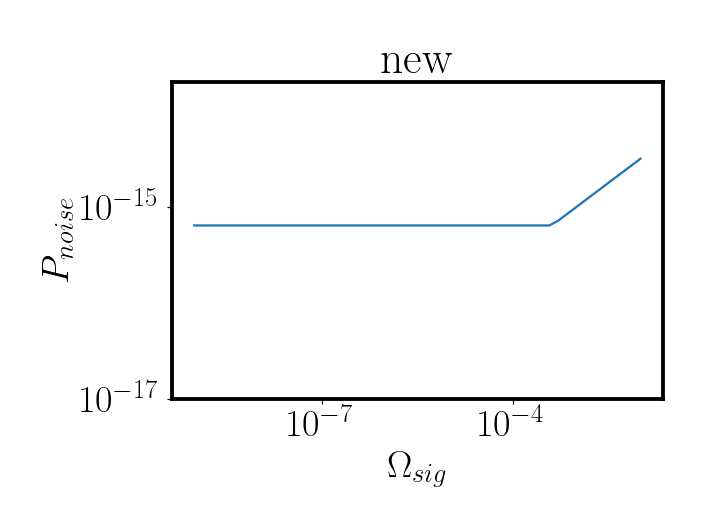

In [88]:
Omega_sig_arr = np.logspace(-9, -2)
exper_mode = sk.SKA_exper_nu(nu=1)
_, _, _, Omega_res, _, _ = sk.SKA_specs(nu=1, exper_mode=exper_mode, correlation_mode='single dish')
pnoise_arr = ap.P_noise(T_noise=100, delnu=1e-3, tobs=100, Omega_obs=Omega_sig_arr, Omega_res=Omega_res, nu=1, correlation_mode='single dish')
plt.subplots()
plt.plot(Omega_sig_arr, pnoise_arr)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-17,2e-14)
plt.xlabel(r'$\Omega_{sig}$')
plt.ylabel(r"$P_{noise}$")
plt.title('new')
plt.tight_layout()

# Varying one parameter at a time

Make a plot to specifically compare different DM profiles 
only with age band, no extra constraints. 

- a 'central' one. then move one parameter at a time
- Burkert vs NFW
- Lpk 
- ell-b
- D varying

In [69]:
def add_band(show_ghosh=True, color='forestgreen', alpha=0.5, t_extra_old_arr=[0, 4e4]):
    Nma = 500
    nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
    numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)

    ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
    ga_new = ga_ref

    res_dct = {}
    #t_extra_old_arr = [0, 4e4]
    #t_extra_old_arr = [4e4]
    for t_extra_old in t_extra_old_arr:
        Snu_echo_kwargs['t_extra_old'] = t_extra_old
        #print(Snu_echo_kwargs)
        routine_out = {}
        bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                     source_input=source_input,
                                     data=data,
                                     Snu_echo_kwargs=Snu_echo_kwargs)
        res_dct[str(int(t_extra_old))] = bounds_out
     
    #
    # plot it away
    #
    z_val = 2.    
    if show_ghosh:
        ghosh = np.loadtxt("../data/cygA_bounds.csv", delimiter=",")    
        # existing echo bounds
        ax.plot(ghosh[:,0], ghosh[:,1]*sqrt(z_val), color=[0.5,0.5,0.5], ls='--')


    #for key in t_extra_old_arr: 

    key = t_extra_old_arr[0]
    key = str(int(key))
    bounds_out = res_dct[key]
    ga_reach = ec.ga_reach(z_val, bounds_out['S/N'], bounds_out['ga'])
    ma_ga0 = np.vstack((ma_new, ga_reach)).T       

    if len(t_extra_old_arr) > 1:
        key = t_extra_old_arr[1]
        key = str(int(key))
        bounds_out = res_dct[key]
        ga_reach = ec.ga_reach(z_val, bounds_out['S/N'], bounds_out['ga'])
        ma_ga1 = np.vstack((ma_new, ga_reach)).T 

        #ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., label='%s' %key, color='forestgreen', alpha=0.5, zorder=100)
        ax.fill_between(ma_ga0[:,0], ma_ga0[:,1], ma_ga1[:,1], label='%s' %key, color=color, alpha=alpha)
    else:
        ax.plot(ma_ga0[:,0], ma_ga0[:,1], label='%s' %key, color=color, alpha=alpha)
        
    #ax.text(3e-5, 3e-10, r"{\bf SNR}", fontdict={'size':25}, color='w', zorder=101)

    title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, sr={sr:.1e}, S/N={sn:.0f}, DM profile={DM_profile}"
    title = title_str.format(D=D,
                     log10Lpk=np.log10(L_peak), 
                     log10tpk=np.log10(t_peak),
                     ell=longitude,
                     b=latitude,
                     alpha=alpha,
                     sr=ang_size, 
                     sn=z_val,
                     DM_profile=DM_profile)

    #ax.set_title(title, fontdict={'fontsize': 17})
    fig.tight_layout()
    #plt.savefig('../plots/projection_old_logLpk_%.1f_logtpk_%.1f_ell_%.1f_b_%.1f_snr_%d_sr_%.1e_D_%.1f_alpha_%.1f_%s.png' %(np.log10(L_peak), np.log10(t_peak), longitude, latitude, z_val, ang_size, D, alpha, DM_profile))

    

<IPython.core.display.Javascript object>


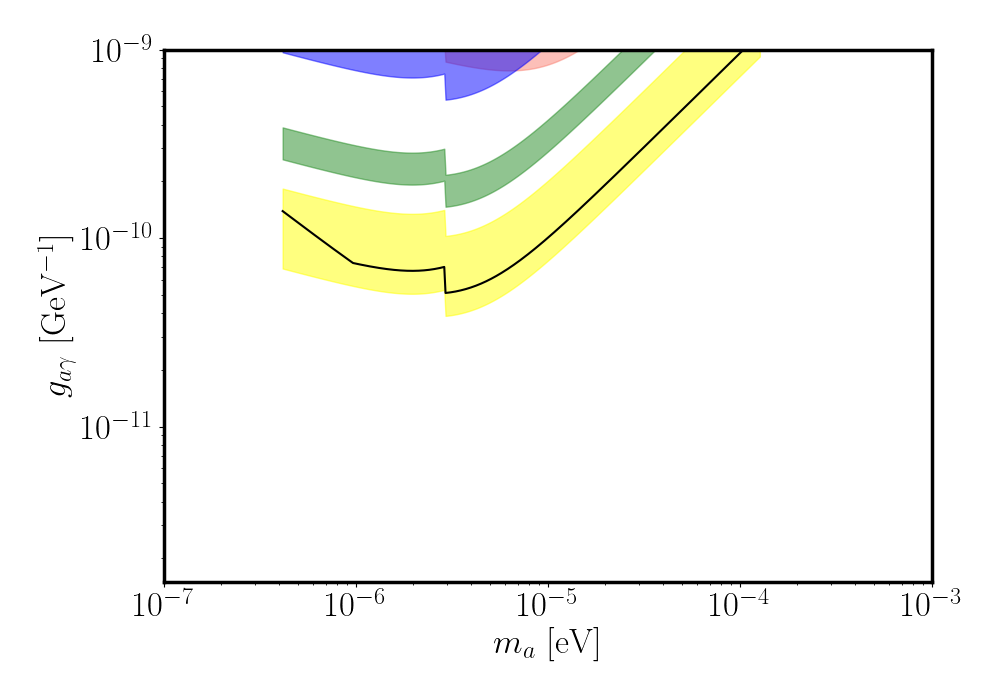

/home/chen/Code/axion_laser/github/workspace_notebooks/../astro.py:902: RuntimeWarning: divide by zero encountered in true_divide
  sqrt(Omega_obs/Omega_res)
/home/chen/Code/axion_laser/github/workspace_notebooks/../echo.py:1142: RuntimeWarning: divide by zero encountered in true_divide
  return ga_ref * sqrt(sn_val/sn_ref)


In [71]:
# canvas setup
fig, ax = gen_constraints(show_bounds=False);

# central instance
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 170 
latitude = 0. 
L_peak = 10**(25.5+1.6*2.)
t_peak = 10**1.7
t_trans = t_peak * 30./365
D = 1. #[kpc]
alpha = 0.5
gamma = ap.gamma_from_alpha(alpha)
ang_size = 1e-5
source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':1e4, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans
               }
ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)
data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}

#add_band(show_ghosh=False, color='k', alpha=0.7)
add_band(show_ghosh=False, color='k', alpha=1., t_extra_old_arr=[4e4])





# instance 2 (burkert)
DM_profile = "Burkert" #"Burkert" # "NFW"
longitude = 170 
latitude = 0. 
L_peak = 10**(25.5+1.6*2.)
t_peak = 10**1.7
t_trans = t_peak * 30./365
D = 1. #[kpc]
alpha = 0.5
gamma = ap.gamma_from_alpha(alpha)
ang_size = 1e-4 
source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':1e4, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans
               }
ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)
data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}

add_band(show_ghosh=False)







# one instance (longi 10)
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 10 
latitude = 0. 
L_peak = 10**(25.5+1.6*2.)
t_peak = 10**1.7
t_trans = t_peak * 30./365
D = 1. #[kpc]
alpha = 0.5
gamma = ap.gamma_from_alpha(alpha)
ang_size = 1e-4 
source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':1e4, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans
               }
ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)
data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}

add_band(show_ghosh=False, color='salmon')






# instance (L_pk 1 sigma)
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 170 
latitude = 0. 
L_peak = 10**(25.5+1.6*1.)
t_peak = 10**1.7
t_trans = t_peak * 30./365
D = 1. #[kpc]
alpha = 0.5
gamma = ap.gamma_from_alpha(alpha)
ang_size = 1e-4 
source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':1e4, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans
               }
ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)
data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}

add_band(show_ghosh=False, color='blue')



# central instance (D)
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 170 
latitude = 0. 
L_peak = 10**(25.5+1.6*2.)
t_peak = 10**1.7
t_trans = t_peak * 30./365
D = 0.45 #[kpc]
alpha = 0.5
gamma = ap.gamma_from_alpha(alpha)
ang_size = 1e-4 
source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':1e4, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans
               }
ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)
data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}

add_band(show_ghosh=False, color='yellow')


plt.savefig('../plots/varying_one_param_at_a_time.pdf')

# Slices -- interactive

### $\ell-b$ contours

In [21]:
# do a few different locations for NFW and compare them to make the point

In [22]:
# then do a contour

In [72]:
# central instance
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 170 
latitude = 0. 
L_peak = 10**(25.5+1.6*2.)
t_peak = 10**1.7
t_trans = t_peak * 30./365
D = 1. #[kpc]
alpha = 0.5
gamma = ap.gamma_from_alpha(alpha)
ang_size = 1e-4 
source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':1e4, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans
               }
ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)
data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}

In [75]:
# l-b contour
#t_extra_old = 4e4
t_extra_old_arr = [0., 1e3, 1e4, 2e4, 3e4, 4e4, 5e4]
z_val = 2.
l_span = 180
b_span = 90
l_arr = np.linspace(180-l_span, 180+l_span, 20)
b_arr = np.linspace(-b_span, b_span, 20)
(l_mesh, b_mesh) = np.meshgrid(l_arr, b_arr, indexing='ij')
(l_flat, b_flat) = (l_mesh.reshape(-1), b_mesh.reshape(-1))
                    
ga_flat = []

# prepare ma grid
Nma = 10
nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)
ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
ga_new = ga_ref

# scan
for i in tqdm(range(len(l_flat))):
    longitude = l_flat[i]
    latitude = b_flat[i]
    source_input['longitude'] = longitude
    source_input['latitude'] = latitude
    
    ga_reach = 1.
    for t_extra_old in t_extra_old_arr:
        Snu_echo_kwargs['t_extra_old'] = t_extra_old    
        routine_out = {}
        bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                     source_input=source_input,
                                     data=data,
                                     Snu_echo_kwargs=Snu_echo_kwargs)
        ga_reach = min(ga_reach, min(ec.ga_reach(z_val, bounds_out['S/N'], bounds_out['ga'])))
    ga_flat.append(ga_reach)
    
ga_flat = np.array(ga_flat)
ga_mesh = ga_flat.reshape(l_mesh.shape)

100%|██████████| 900/900 [04:20<00:00,  3.45it/s]


<IPython.core.display.Javascript object>


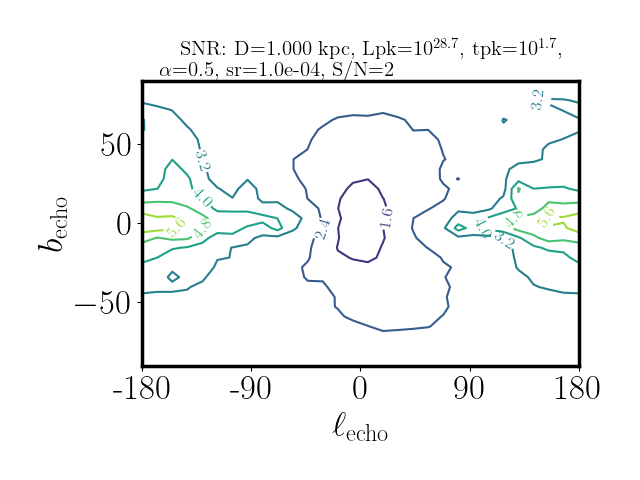

saved at ../plots/projection_old_logLpk_28.7_logtpk_1.7_snr_2_sr_1.0e-04_D_1.0_alpha_0.5_teo_vary_size_180x90.png


In [76]:
_, ax = plt.subplots()
#cs = plt.contour(l_mesh, b_mesh, np.log10(ga_mesh))
#cs = plt.contourf(l_mesh, b_mesh, np.log10(ga_mesh))
cs = plt.contour(l_mesh, b_mesh, ga_mesh*1e10)
#cs = plt.contourf(l_mesh, b_mesh, ga_mesh*1e10)
ax.clabel(cs, inline=1, fontsize=12)

#title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\alpha$={alpha:.1f}, sr={sr:.1e}, S/N={sn:.0f}, t\_extra\_old={t_extra_old:.0f}"
#title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\alpha$={alpha:.1f}, sr={sr:.1e}, S/N={sn:.0f}, t\_extra\_old=vary"
title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\alpha$={alpha:.1f}, sr={sr:.1e}, S/N={sn:.0f}"
title = title_str.format(D=D,
                 log10Lpk=np.log10(L_peak), 
                 log10tpk=np.log10(t_peak),
#                  ell=longitude,
#                  b=latitude,
                 alpha=alpha,
                 sr=ang_size, 
                 sn=z_val) 
#                  t_extra_old=t_extra_old)

plt.title(title, fontdict={'size':15})
#plt.xlabel(r'$\ell - 180^\circ$')
plt.xlabel(r'$\ell_{\rm  echo}$')
plt.ylabel(r'$b_{\rm echo}$')
xold = (np.linspace(l_arr[0], l_arr[-1], 5)).astype(int)
xnew = xold - 180
plt.xticks(xold, xnew)
plt.tight_layout()
#plt.savefig('./plots/l_b_contours/projection_old_logLpk_%.1f_logtpk_%.1f_snr_%d_sr_%.1e_D_%.1f_alpha_%.1f_teo_%.0f_size_%.0fx%.0f.png' %(np.log10(L_peak), np.log10(t_peak), z_val, ang_size, D, alpha, t_extra_old, l_span, b_span))
plt.savefig('../plots/projection_old_logLpk_%.1f_logtpk_%.1f_snr_%d_sr_%.1e_D_%.1f_alpha_%.1f_teo_%s_size_%.0fx%.0f.png' %(np.log10(L_peak), np.log10(t_peak), z_val, ang_size, D, alpha, "vary", l_span, b_span))
print('saved at ../plots/projection_old_logLpk_%.1f_logtpk_%.1f_snr_%d_sr_%.1e_D_%.1f_alpha_%.1f_teo_%s_size_%.0fx%.0f.png' %(np.log10(L_peak), np.log10(t_peak), z_val, ang_size, D, alpha, "vary", l_span, b_span))


### $\ell$-distance contours

In [84]:
plt.rcParams['axes.linewidth'] = 1.5
plt.rc('font', family='serif',size=20)


In [85]:
# DM profile
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = None
latitude = 0.

# SNR property
alpha = 0.5
nu_Biet = 5. # GHz
nu_pivot = 1.
L_peak_Biet = 10**(25.5+1.6*2.)
L_peak = L_peak_Biet * (nu_Biet/nu_pivot) ** alpha # converting Bietenholz freq to nupivot
t_peak = 10**1.7
t_trans = t_peak * 30./365
D = None 
gamma = ap.gamma_from_alpha(alpha)
ang_size = 1e-5
t_age = 1e4
t_extra_old = 4e4

source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':t_age, 
                'alpha':alpha,
                'nu_pivot':nu_pivot,
                'gamma':gamma,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans
               }

ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)

data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':t_extra_old}    

z_val = 2.
ga_flat = []

# # prepare ma grid
# Nma = 20
# nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
# numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)
# ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
# ga_new = ga_ref

# alternatively: fix ma to 1GHz
ma_new = np.array([pt.ma_from_nu(1)])
ga_new = ga_ref



In [86]:
ell_arr = np.linspace(180, 360, 50)
D_arr = np.logspace(-1, 0.5, 30)
ell_mesh, D_mesh = np.meshgrid(ell_arr, D_arr, indexing='ij')
ell_flat, D_flat = ell_mesh.reshape(-1), D_mesh.reshape(-1)


def scan(i):
    # scan
    source_input['longitude'] = ell_flat[i]
    source_input['distance'] = D_flat[i]
    ga_reach = 1. 
    routine_out = {}
    bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                 source_input=source_input,
                                 data=data,
                                 Snu_echo_kwargs=Snu_echo_kwargs)
    ga_reach = min(ga_reach, min(ec.ga_reach(z_val, bounds_out['S/N'], bounds_out['ga'])))
    return ga_reach

In [87]:
# python 2 probably needs to use contextlib as 
# Pool() wasn't a context manager in 2.x yet
# from contextlib import closing
# with closing(Pool(processes=2)) as pool:

with Pool() as pool:
    ga_flat = pool.map(scan, range(len(ell_flat)))
    pool.close()
    pool.join()
    
ga_flat = np.array(ga_flat)
ga_mesh = ga_flat.reshape(ell_mesh.shape)    

<IPython.core.display.Javascript object>


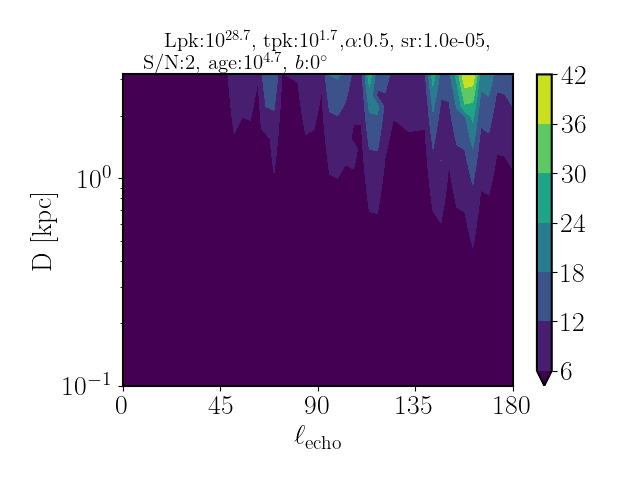

In [88]:
_, ax = plt.subplots()
#cs = plt.contour(ell_mesh, D_mesh, np.log10(ga_mesh))
#cs = plt.contour(ell_mesh, D_mesh, ga_mesh*1e10)
cs = plt.contourf(ell_mesh, D_mesh, ga_mesh*1e10, extend='min')
#ax.clabel(cs, inline=1, fontsize=12)

title_str = r"Lpk:10$^{{{log10Lpk:.1f}}}$, tpk:10$^{{{log10tpk:.1f}}}$,$\alpha$:{alpha:.1f}, sr:{sr:.1e}, \\S/N:{sn:.0f}, age:10$^{{{log10age:.1f}}}$, $b$:{b:.0f}$^\circ$"
title = title_str.format(
                 log10Lpk=np.log10(L_peak_Biet), 
                 log10tpk=np.log10(t_peak),
                 alpha=alpha,
                 sr=ang_size, 
                 sn=z_val,
                log10age=np.log10(source_input['t_age'] + Snu_echo_kwargs['t_extra_old']),
#                 ell=longitude,
                 b=latitude
)

xold = (np.linspace(ell_arr[0], ell_arr[-1], 5)).astype(int)
xnew = xold - 180
plt.xticks(xold, xnew)
plt.title(title, fontdict={'size':15})
plt.xlabel(r'$\ell_{\rm  echo}$')
plt.ylabel('D [kpc]')
plt.yscale('log')
cbar = plt.colorbar(cs)
plt.tight_layout()

path = '../plots/projection_D_ell_scan.pdf'
plt.savefig(path)

### age-$t_{trans}/t_{pk}$ contours

In [89]:
plt.rcParams['axes.linewidth'] = 1.5
plt.rc('font', family='serif',size=20)

In [90]:
# DM profile
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 170.
latitude = 0.

# SNR property
alpha = 0.5
nu_Biet = 5. # GHz
nu_pivot = 1.
L_peak_Biet = 10**(25.5+1.6*2.)
L_peak = L_peak_Biet * (nu_Biet/nu_pivot) ** alpha # converting Bietenholz freq to nupivot
t_peak = 10**1.7
t_trans = None
D = 0.5 #[kpc]
gamma = ap.gamma_from_alpha(alpha)
ang_size = 1e-4 
t_age = 1e4

source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':t_age, 
                'alpha':alpha,
                'nu_pivot':nu_pivot,
                'gamma':gamma,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans
               }
ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)
data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}    

z_val = 2.
ga_flat = []

# # prepare ma grid
# Nma = 20
# nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
# numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)
# ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
# ga_new = ga_ref

# alternatively: fix ma to 1GHz
ma_new = np.array([pt.ma_from_nu(1.)])
ga_new = ga_ref


In [91]:
age_arr = np.linspace(0, 6e4, 50)
trpk_arr = np.linspace(10, 50, 30)
age_mesh, trpk_mesh = np.meshgrid(age_arr, trpk_arr, indexing='ij')
age_flat, trpk_flat = age_mesh.reshape(-1), trpk_mesh.reshape(-1)


def scan(i):
    # scan
    Snu_echo_kwargs['t_extra_old'] = age_flat[i]
    source_input['t_trans'] = trpk_flat[i] * source_input['t_peak'] / 365
    ga_reach = 1. 
    routine_out = {}
    bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                 source_input=source_input,
                                 data=data,
                                 Snu_echo_kwargs=Snu_echo_kwargs)
    ga_reach = min(ga_reach, min(ec.ga_reach(z_val, bounds_out['S/N'], bounds_out['ga'])))
    return ga_reach

In [92]:
# python 2 probably needs to use contextlib as 
# Pool() wasn't a context manager in 2.x yet
# from contextlib import closing
# with closing(Pool(processes=2)) as pool:
with Pool() as pool:
    ga_flat = pool.map(scan, range(len(age_flat)))
    pool.close()
    pool.join()
    
ga_flat = np.array(ga_flat)
ga_mesh = ga_flat.reshape(age_mesh.shape)    

<IPython.core.display.Javascript object>


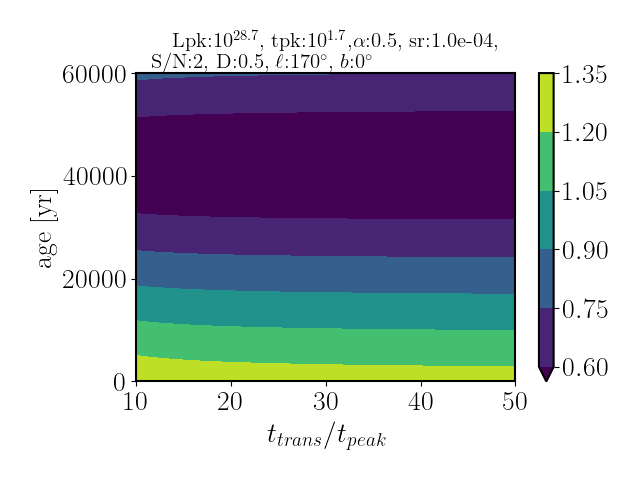

In [93]:
_, ax = plt.subplots()
#cs = plt.contour(ell_mesh, D_mesh, np.log10(ga_mesh))
#cs = plt.contour(ell_mesh, D_mesh, ga_mesh*1e10)
#cs = plt.contourf(ell_mesh, D_mesh, ga_mesh*1e10, extend='min')
#ax.clabel(cs, inline=1, fontsize=12)
cs = plt.contourf(trpk_mesh, age_mesh, ga_mesh*1e10, extend='min')

title_str = r"Lpk:10$^{{{log10Lpk:.1f}}}$, tpk:10$^{{{log10tpk:.1f}}}$,$\alpha$:{alpha:.1f}, sr:{sr:.1e}, \\S/N:{sn:.0f}, D:{D:.1f}, $\ell$:{ell:.0f}$^\circ$, $b$:{b:.0f}$^\circ$"
title = title_str.format(
                 log10Lpk=np.log10(L_peak_Biet), 
                 log10tpk=np.log10(t_peak),
                 alpha=alpha,
                 sr=ang_size, 
                 sn=z_val, 
                 D=D,
                ell=longitude,
                b=latitude)

plt.title(title, fontdict={'size':15})
plt.xlabel(r'$t_{trans}/t_{peak}$')
plt.ylabel(r'age [yr]')
#plt.yscale('log')
cbar = plt.colorbar(cs)
plt.tight_layout()

path = '../plots/projection_ttranstpk_age_scan.pdf'
plt.savefig(path)

### $L_{pk} - t_{pk}$ contours

In [131]:
plt.rcParams['axes.linewidth'] = 1.5
plt.rc('font', family='serif',size=20)

In [132]:
# DM profile
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 170.
latitude = 0.

# SNR property
alpha = 0.5
nu_Biet = 5. # GHz
nu_pivot = 1.
L_peak = None 
t_peak = None #10**1.7
t_trans = None
D = 0.5 #[kpc]
gamma = ap.gamma_from_alpha(alpha)
ang_size = 1e-4 
t_age = 1e4
t_extra_old = 4e4

source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':t_age, 
                'alpha':alpha,
                'nu_pivot':nu_pivot,
                'gamma':gamma,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans
               }
ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)
data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile
       }

t_age = source_input['t_age']
Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':t_extra_old}    

z_val = 2.
ga_flat = []

# # prepare ma grid
# Nma = 20
# nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
# numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)
# ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
# ga_new = ga_ref

# alternatively: fix ma to 1GHz
ma_new = np.array([pt.ma_from_nu(1)])
ga_new = ga_ref


In [146]:
Lpk_Biet_arr = np.logspace(25.5-1.6*3., 25.5+1.6*3., 50)
Lpk_arr = Lpk_Biet_arr * (nu_Biet/nu_pivot) ** alpha # convert to Pivot freq
tpk_arr = np.logspace(1.7-0.9*3, 1.7+0.9*3, 30)

Lpk_mesh, tpk_mesh = np.meshgrid(Lpk_arr, tpk_arr, indexing='ij')
Lpk_Biet_mesh, _ = np.meshgrid(Lpk_Biet_arr, tpk_arr, indexing='ij')

Lpk_flat, tpk_flat = Lpk_mesh.reshape(-1), tpk_mesh.reshape(-1)


def scan(i, debug=False):
    # scan
    source_input['L_peak'] = Lpk_flat[i]
    source_input['t_peak'] = tpk_flat[i]
    source_input['t_trans'] = 30. * source_input['t_peak'] / 365.
    ga_reach = 1. 
    routine_out = {}
    bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                 source_input=source_input,
                                 data=data,
                                 Snu_echo_kwargs=Snu_echo_kwargs)
    #print(bounds_out.keys())
    #print(bounds_out['ga'])
    ga_reach = min(ga_reach, min(ec.ga_reach(z_val, bounds_out['S/N'], bounds_out['ga'])))
    if debug is False:
        return ga_reach
    else:
        return ga_reach, bounds_out

In [142]:
_, bounds_out = scan(2, debug=True)
bounds_out

{'echo_Snu': array([9.20758827e-15]),
 'signal_nu': array([1.]),
 'signal_delnu': array([0.001]),
 'signal_Omega': 0.0001,
 'signal_Snu': array([9.20758827e-15]),
 'signal_S_echo': array([1.47290338e-44]),
 'signal_power': array([2.18185832e-25]),
 'noise_nu': array([1.]),
 'noise_delnu': array([0.001]),
 'noise_Omega_res': array(7.20993788e-08),
 'noise_Omega_obs': 0.0001,
 'noise_T408': array(42.091976, dtype=float32),
 'noise_Tnu': array([30.00489852]),
 'noise_power': array([5.29582564e-16]),
 'S/N': array([4.11995876e-10]),
 'ma': array([8.27133561e-06]),
 'ga': 1e-10}

In [143]:
# python 2 probably needs to use contextlib as 
# Pool() wasn't a context manager in 2.x yet
# from contextlib import closing
# with closing(Pool(processes=2)) as pool:
with Pool() as pool:
    ga_flat = pool.map(scan, range(len(tpk_flat)))
    pool.close()
    pool.join()
    
ga_flat = np.array(ga_flat)
ga_mesh = ga_flat.reshape(tpk_mesh.shape)    

<IPython.core.display.Javascript object>


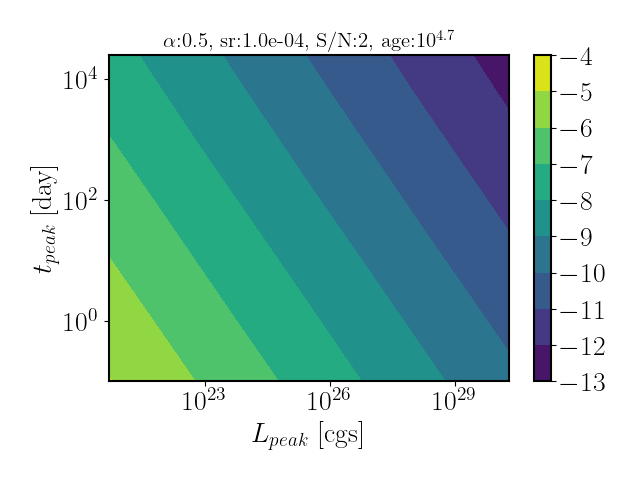

In [148]:
_, ax = plt.subplots()
#cs = plt.contour(ell_mesh, D_mesh, np.log10(ga_mesh))
#cs = plt.contour(ell_mesh, D_mesh, ga_mesh*1e10)
#cs = plt.contourf(ell_mesh, D_mesh, ga_mesh*1e10, extend='min')
#ax.clabel(cs, inline=1, fontsize=12)
#cs = plt.contourf(Lpk_mesh, tpk_mesh, ga_mesh*1e10, extend='min')
#cs = plt.contourf(Lpk_mesh, tpk_mesh, np.log10(ga_mesh), extend='min')
cs = plt.contourf(Lpk_Biet_mesh, tpk_mesh, np.log10(ga_mesh))#, extend='min')

title_str = r"$\alpha$:{alpha:.1f}, sr:{sr:.1e}, S/N:{sn:.0f}, age:10$^{{{log10age:.1f}}}$"
title = title_str.format(
                 alpha=alpha,
                 sr=ang_size, 
                 sn=z_val,
                 log10age=np.log10(source_input['t_age'] + Snu_echo_kwargs['t_extra_old']) )

plt.title(title, fontdict={'size':15})
plt.xlabel(r'$L_{peak}$ [cgs]')
plt.ylabel(r'$t_{peak}$ [day]')
plt.yscale('log')
plt.xscale('log')
cbar = plt.colorbar(cs)
plt.tight_layout()

path = '../plots/projection_Lpk_tpk_scan.pdf'
#plt.savefig(path)

# Plots with script runs

Every below requires running run_custom.py to generate the data file first.

### CASE 1: Lpk-tpk

`python ./run_custom.py --run 0 --nuB 5 --Nsteps 30 Lpk-tpk --dist 0.5 --tt_ratio 30 --t0 1e4 --t_extra 4e4 --long_lat 178 0`

<IPython.core.display.Javascript object>


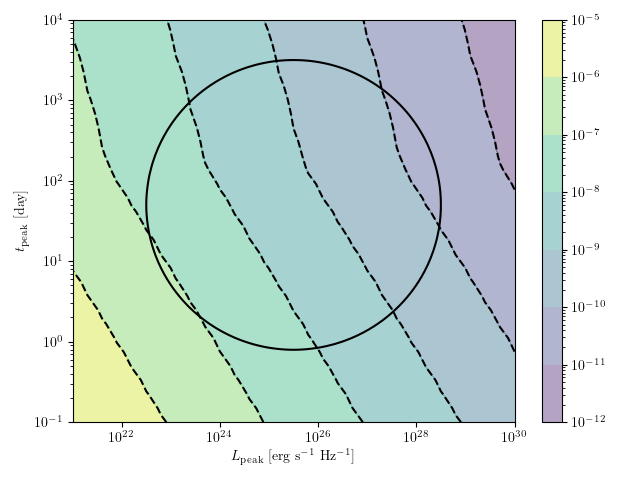

In [4]:
run_id = 3
ga_ref = 1e-10
mode = 'Lpk-tpk'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator())
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator())

#L_peak_Biet = 10**(25.5+1.6*2.)
# plt.vlines([10**(ct._mu_log10_Lpk_ - 2 * ct._sig_log10_Lpk_), 10**(ct._mu_log10_Lpk_ + 2 * ct._sig_log10_Lpk_)], 0.1, 1e6, ls='-', color='C0')
L_Biet_arr = np.logspace(ct._mu_log10_Lpk_ - 2 * ct._sig_log10_Lpk_, ct._mu_log10_Lpk_ + 2 * ct._sig_log10_Lpk_, 100)
t_Biet_arr = np.logspace(ct._mu_log10_tpk_ - 2 * ct._sig_log10_tpk_, ct._mu_log10_tpk_ + 2 * ct._sig_log10_tpk_, 100)
L_Biet_mesh, t_Biet_mesh = np.meshgrid(L_Biet_arr, t_Biet_arr, indexing='ij')
L_Biet_flat, t_Biet_flat = L_Biet_mesh.reshape(-1), t_Biet_mesh.reshape(-1)
sigma_flat = []
for i in range(len(L_Biet_flat)):
    L = L_Biet_flat[i]
    t = t_Biet_flat[i]
    sigma = np.sqrt((np.log10(L) - ct._mu_log10_Lpk_)**2/ct._sig_log10_Lpk_**2 + (np.log10(t) - ct._mu_log10_tpk_)**2/ct._sig_log10_tpk_**2)
    sigma_flat.append(sigma)

sigma_mesh = np.array(sigma_flat).reshape(L_Biet_mesh.shape)
plt.contour(L_Biet_mesh, t_Biet_mesh, sigma_mesh, colors=['k'], linestyles=['-'], levels=[2])
    
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e21, 1e30)
plt.ylim(0.1, 1e4)
# plt.title(title, fontdict={'size':15})
plt.xlabel(r'$L_{\rm peak}$ [erg s$^{-1}$ Hz$^{-1}$]')
plt.ylabel(r'$t_{\rm peak}$ [day]')
plt.tight_layout()

path = '../plots/projection_case1_Lpk_tpk_scan.pdf'
plt.savefig(path)

### CASE 2: $t_{trans}/t_{peak}$ vs $t_0$

`python ./run_custom.py --run 0 --nuB 5 --Nsteps 30 r-tsig --Lpk 3.16e28 --tpk 50.1 --dist 0.5 --long_lat 178 0`

<IPython.core.display.Javascript object>


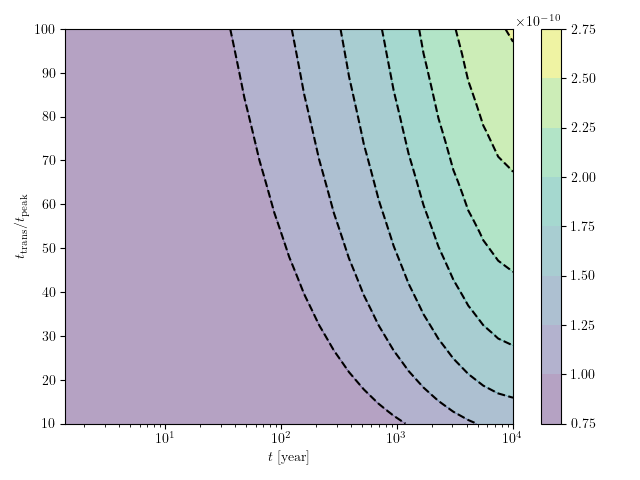

In [5]:
run_id = 3
ga_ref = 1e-10
mode = 'tsig-r'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4)
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'])
# plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$t_{\rm trans}/t_{\rm peak}$')
plt.tight_layout()
path = '../plots/projection_case2_r-tsig.pdf'
plt.savefig(path)

### CASE 3: ttrans vs $t_{extra}$
    
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 30 r-tex --Lpk 3.16e28 --tpk 50.1 --dist 0.5 --long_lat 178 0`

<IPython.core.display.Javascript object>


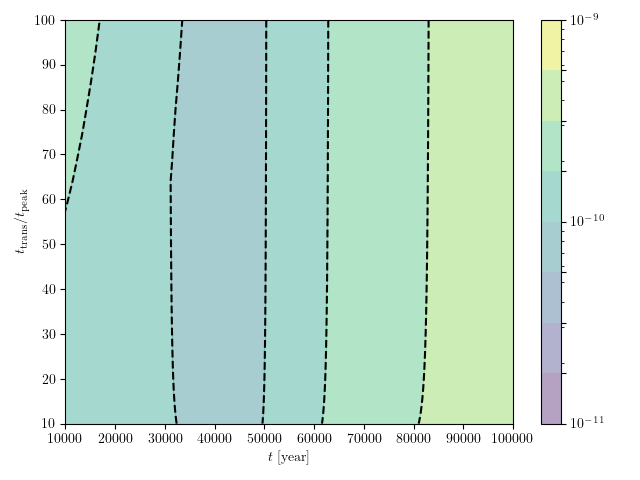

In [6]:
run_id = 3
ga_ref = 1e-10
mode = 'tex-r'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 9))
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 9))
# plt.yscale('log')
# plt.xscale('log')
plt.xlim(1e4, 1e5)

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$t_{\rm trans}/t_{\rm peak}$')
plt.tight_layout()
path = '../plots/projection_case3_r_tex_scan.pdf'
plt.savefig(path)

### CASE 4: $\ell$ vs $D$
    
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 100 l-D --Lpk 3.16e28 --tpk 50.1 --tt_ratio 30 --t0 1e4 --t_extra 4e4 --lat 0`

<IPython.core.display.Javascript object>


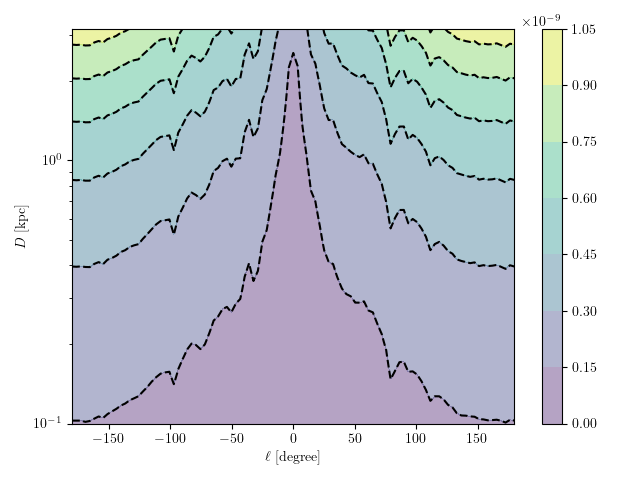

In [7]:
run_id = 3
ga_ref = 1e-10
mode = 'l-D'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr-180, y_arr, (ga_reach_flat), alpha=0.4)#, locator=ticker.LogLocator())

plt.colorbar(cs)
plt.contour(x_arr-180, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'])#, locator=ticker.LogLocator())
# plt.yscale('log')
plt.yscale('log')

plt.xlabel(r'$\ell$ [degree]')
plt.ylabel(r'$D$ [kpc]')
plt.tight_layout()
path = '../plots/projection_case4_l_D_scan.pdf'
plt.savefig(path)

### CASE 5: $\ell$ vs $b$
    
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 30 l-b --Lpk 3.16e28 --tpk 50.1 --dist 0.5 --tt_ratio 30 --t0 1e4 --t_extra 4e4`

<IPython.core.display.Javascript object>


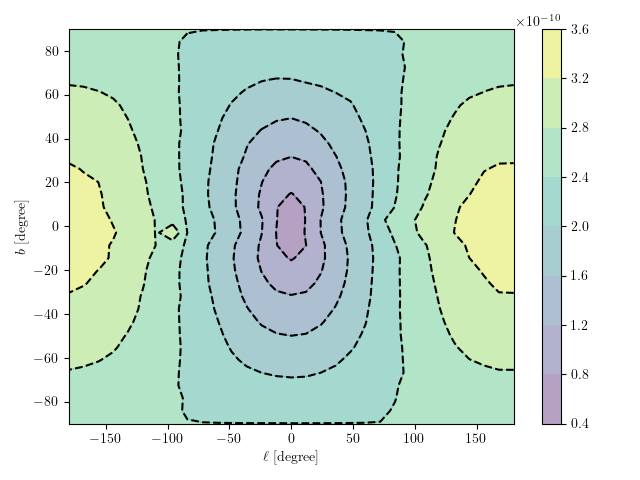

In [8]:
run_id = 3
ga_ref = 1e-10
mode = 'l-b'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr-180, -y_arr, (ga_reach_flat), alpha=0.4)#, locator=ticker.LogLocator())
plt.colorbar(cs)
plt.contour(x_arr-180, -y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'])#, locator=ticker.LogLocator())
# plt.yscale('log')
# plt.xscale('log')

plt.ylabel(r'$b$ [degree]')
plt.xlabel(r'$\ell$ [degree]')
plt.tight_layout()
path = '../plots/projection_case5_l_b_scan.pdf'
plt.savefig(path)

### CASE 6: t-D
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 30 D-t --Lpk 3.16e28 --tpk 50.1 --tt_ratio 30 -lb 178 0`

<IPython.core.display.Javascript object>


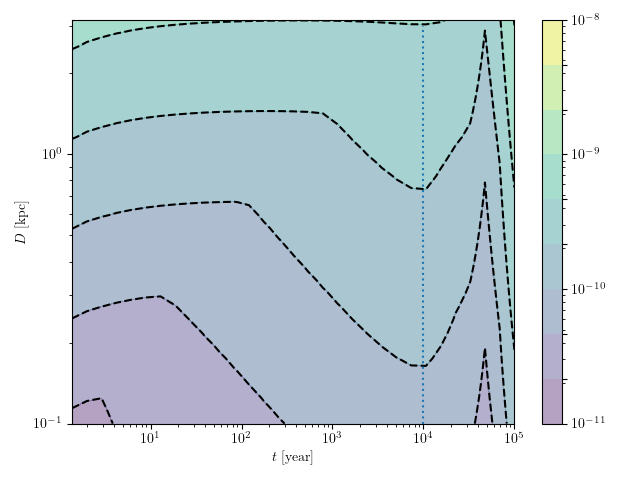

In [9]:
run_id = 3
ga_ref = 1e-10
mode = 't-D'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.yscale('log')
plt.xscale('log')
plt.vlines(1e4, 1e-1, 3, ls=':')

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$D$ [kpc]')
plt.tight_layout()
path = '../plots/projection_case6_D_t_scan.pdf'
plt.savefig(path)

<IPython.core.display.Javascript object>


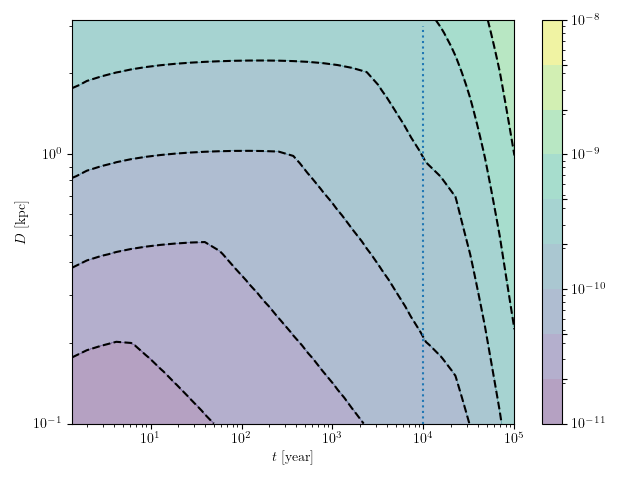

In [10]:
run_id = 99
ga_ref = 1e-10
mode = 't-D'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.yscale('log')
plt.xscale('log')
plt.vlines(1e4, 1e-1, 3, ls=':')

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$D$ [kpc]')
plt.tight_layout()
path = '../plots/projection_case6_D_t_scan.pdf'
plt.savefig(path)

<IPython.core.display.Javascript object>


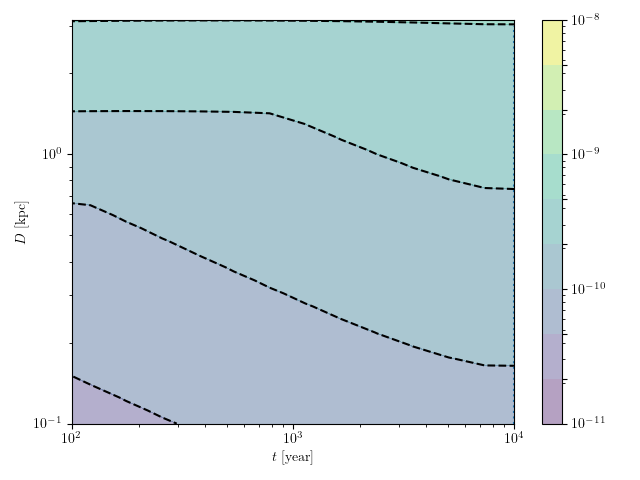

In [11]:
run_id = 3
ga_ref = 1e-10
mode = 't-D'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.xlim(100, 1e4)
plt.yscale('log')
plt.xscale('log')
plt.vlines(1e4, 1e-1, 3, ls=':')

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$D$ [kpc]')
plt.tight_layout()
path = '../plots/projection_case6_D_t_scan_small.pdf'
plt.savefig(path)

<IPython.core.display.Javascript object>


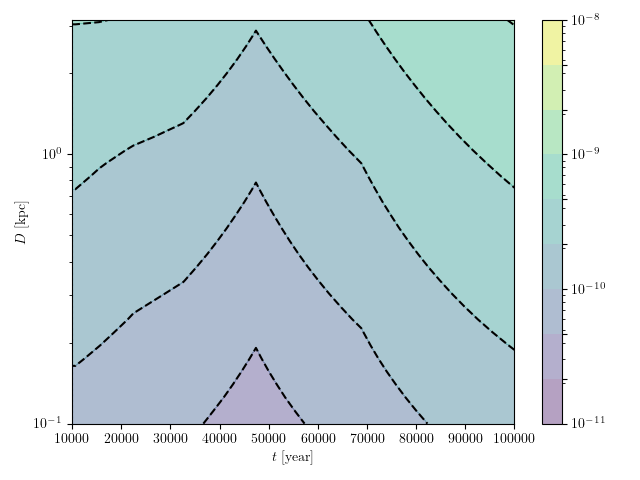

In [12]:
run_id = 3
ga_ref = 1e-10
mode = 't-D'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.xlim(1e4, 1e5)
plt.yscale('log')
#plt.xscale('log')
plt.vlines(1e4, 1e-1, 3, ls=':')

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$D$ [kpc]')
plt.tight_layout()
path = '../plots/projection_case6_D_t_scan_big.pdf'
plt.savefig(path)

### CASE 7: $\ell$-t
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 100 l-t --Lpk 3.16e28 --tpk 50.1 --tt_ratio 30 -D 0.5 -b 0`

<IPython.core.display.Javascript object>


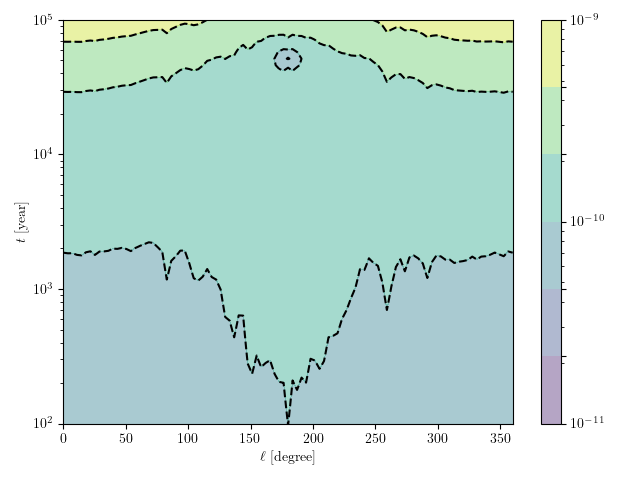

In [13]:
run_id = 3
ga_ref = 1e-10
mode = 'l-t'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
#plt.yscale('log')
plt.yscale('log')
plt.ylim(1e2, 1e5)

plt.xlabel(r'$\ell$ [degree]')
plt.ylabel(r'$t$ [year]')
plt.tight_layout()
path = '../plots/projection_case7_l_t_scan.pdf'
plt.savefig(path)

<IPython.core.display.Javascript object>


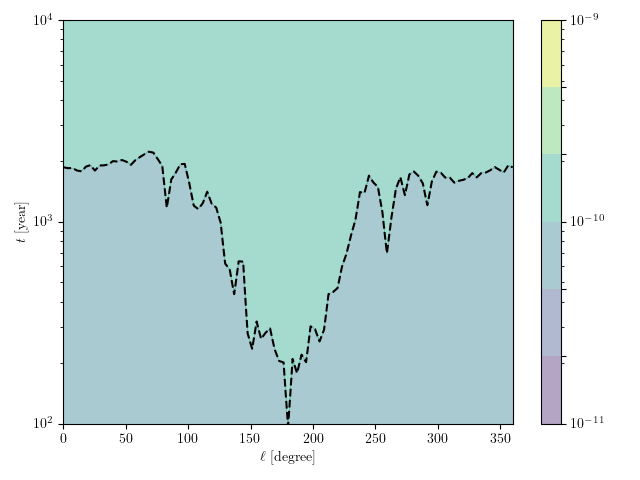

In [14]:
run_id = 3
ga_ref = 1e-10
mode = 'l-t'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
#plt.yscale('log')
plt.yscale('log')
plt.ylim(1e2, 1e4)

plt.ylabel(r'$t$ [year]')
plt.xlabel(r'$\ell$ [degree]')
plt.tight_layout()
path = '../plots/projection_case7_l_t_scan_small.pdf'
plt.savefig(path)

<IPython.core.display.Javascript object>


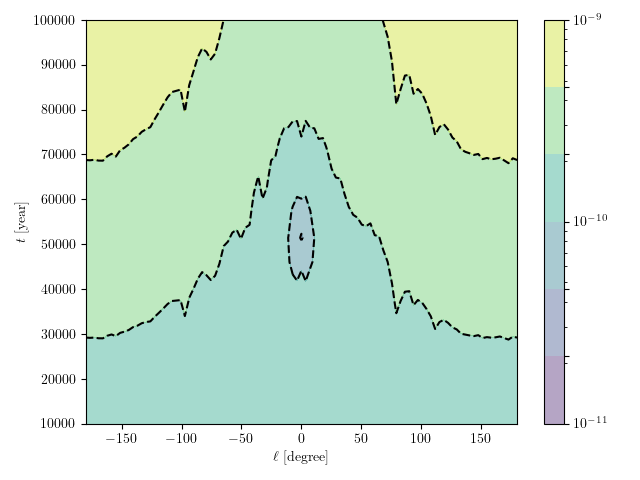

In [15]:
run_id = 3
ga_ref = 1e-10
mode = 'l-t'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr-180, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
plt.colorbar(cs)
plt.contour(x_arr-180, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(1e4, 1e5)

plt.ylabel(r'$t$ [year]')
plt.xlabel(r'$\ell$ [degree]')
plt.tight_layout()
path = '../plots/projection_case7_l_t_scan_big.pdf'
plt.savefig(path)

### CASE 8: $b$-t
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 100 b-t --Lpk 3.16e28 --tpk 50.1 --tt_ratio 30 -D 0.5 -l 178`

<IPython.core.display.Javascript object>


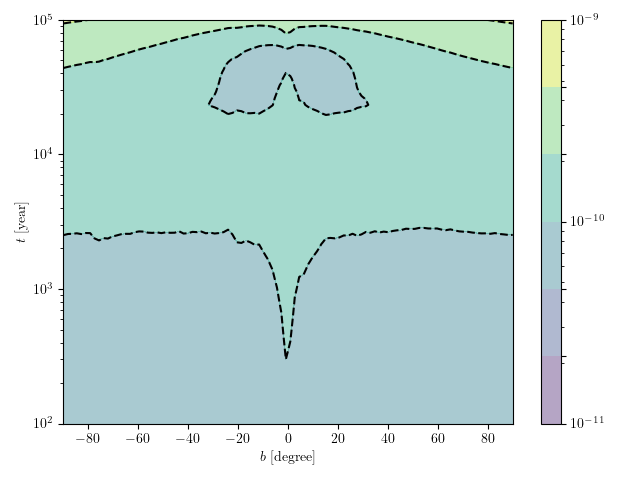

In [16]:
run_id = 3
ga_ref = 1e-10
mode = 't-b'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(y_arr, x_arr, (ga_reach_flat.T), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
plt.colorbar(cs)
plt.contour(y_arr, x_arr, (ga_reach_flat.T), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
#plt.yscale('log')
plt.yscale('log')
plt.ylim(1e2, 1e5)

plt.ylabel(r'$t$ [year]')
plt.xlabel(r'$b$ [degree]')
plt.tight_layout()
path = '../plots/projection_case8_b_t_scan.pdf'
plt.savefig(path)

<IPython.core.display.Javascript object>


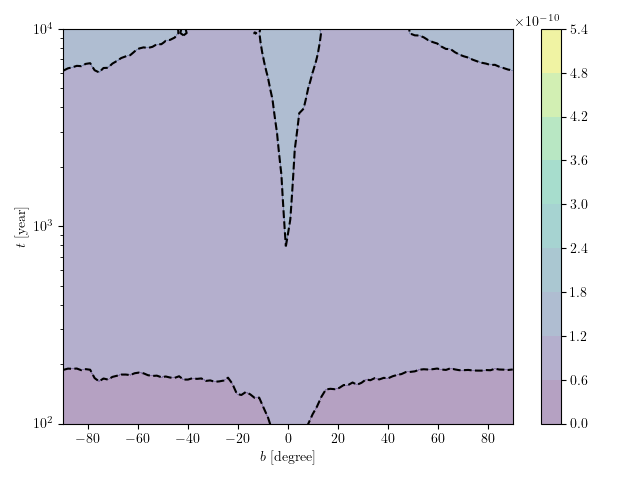

In [17]:
run_id = 3
ga_ref = 1e-10
mode = 't-b'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(y_arr, x_arr, (ga_reach_flat.T), alpha=0.4)
plt.colorbar(cs)
plt.contour(y_arr, x_arr, (ga_reach_flat.T), colors=['k'], linestyles=['--'])
#plt.yscale('log')
plt.yscale('log')
plt.ylim(1e2, 1e4)

plt.ylabel(r'$t$ [year]')
plt.xlabel(r'$b$ [degree]')
plt.tight_layout()
path = '../plots/projection_case8_b_t_scan_small.pdf'
plt.savefig(path)

<IPython.core.display.Javascript object>


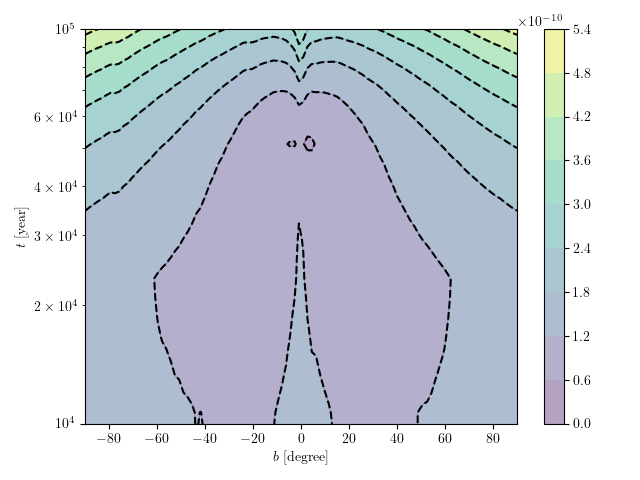

In [18]:
run_id = 3
ga_ref = 1e-10
mode = 't-b'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(y_arr, x_arr, (ga_reach_flat.T), alpha=0.4)
plt.colorbar(cs)
plt.contour(y_arr, x_arr, (ga_reach_flat.T), colors=['k'], linestyles=['--'])
#plt.yscale('log')
plt.yscale('log')
plt.ylim(1e4, 1e5)

plt.ylabel(r'$t$ [year]')
plt.xlabel(r'$b$ [degree]')
plt.tight_layout()
path = '../plots/projection_case8_b_t_scan_big.pdf'
plt.savefig(path)

### CASE 9: $t-S_0$
`python ./run_custom.py --run 1 --nuB 8 --Nsteps 30 t-S0 --tpk 50.1 --tt_ratio 30 -D 0.5 -lb 175 0`

<IPython.core.display.Javascript object>


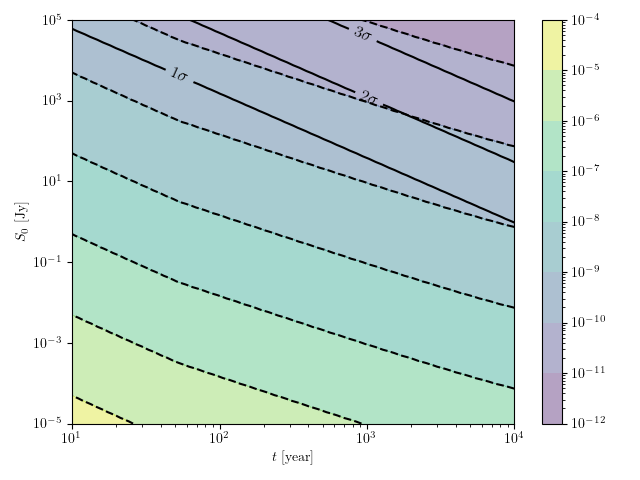

In [19]:
run_id = 11
ga_ref = 1e-10
mode = 't-S0'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-12, -4, 9))
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-12, -4, 9))
#plt.yscale('log')
plt.yscale('log')
plt.xscale('log')




# Bietenholz contours
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_LpkBiet_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
Lpk_Biet_flat = np.loadtxt(target, delimiter=',')
sigma_Biet_flat = (np.log10(Lpk_Biet_flat) - ct._mu_log10_Lpk_)/ct._sig_log10_Lpk_
cs2 = plt.contour(x_arr, y_arr, sigma_Biet_flat, levels=[1,2,3], colors=['k'])

# inline labeling
fmt = {}
strs = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
for l, s in zip(cs2.levels, strs):
    fmt[l] = s
plt.clabel(cs2, cs2.levels, inline=True, fmt=fmt, fontsize=12)


plt.xlabel(r'$t$ [year]')
plt.ylabel(r"$S_0$ [Jy]")
plt.tight_layout()
path = '../plots/projection_case9_t_S0_scan.pdf'
plt.savefig(path)

### adiabatic only

small ttran/tpk, small tpk

`python ./run_custom.py --run 12 --nuB 8 --Nsteps 30 t-S0 --tpk 1 --tt_ratio 1 -D 0.5 -lb 175 0`

<IPython.core.display.Javascript object>


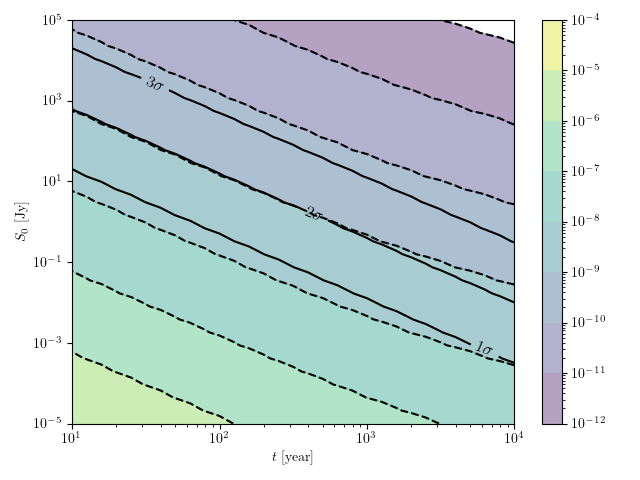

In [4]:
run_id = 12
ga_ref = 1e-10
mode = 't-S0'

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_sn_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_arr = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%d_*_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_arr = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_arr, y_arr, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-12, -4, 9))
plt.colorbar(cs)
plt.contour(x_arr, y_arr, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-12, -4, 9))
#plt.yscale('log')
plt.yscale('log')
plt.xscale('log')




# Bietenholz contours
path = '../output/custom_snr/%s/' %mode
name = 'run_%d_LpkBiet_*' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
Lpk_Biet_flat = np.loadtxt(target, delimiter=',')
sigma_Biet_flat = (np.log10(Lpk_Biet_flat) - ct._mu_log10_Lpk_)/ct._sig_log10_Lpk_
cs2 = plt.contour(x_arr, y_arr, sigma_Biet_flat, levels=[1,2,3], colors=['k'])

# inline labeling
fmt = {}
strs = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
for l, s in zip(cs2.levels, strs):
    fmt[l] = s
plt.clabel(cs2, cs2.levels, inline=True, fmt=fmt, fontsize=12)


plt.xlabel(r'$t$ [year]')
plt.ylabel(r"$S_0$ [Jy]")
plt.tight_layout()
path = '../plots/projection_case9_t_S0_scan.pdf'
plt.savefig(path)